In [1]:
import time
import gappy_kernel as gk
import gappy_trie as gt
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from Bio.Seq import Seq
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve, precision_score

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Reads in files
def read(fname):
    sequences=[]
    with open(fname,'r') as f:
        for line in f:
            if line[0]!='>':
                sequences.append(line.split()[0])
    return sequences

pos=[Seq(x) for x in read('./Tutorialdata/positive_IGF2BP123.fasta')]
neg=[Seq(x) for x in read('./Tutorialdata/negative_IGF2BP123.fasta')]
start = time.time()
k=3
g=2
start = time.time()
spectrum_pos = gk.gappypair_kernel(pos, k=k, g=g,  include_flanking=False, gapDifferent = True)
print ("Calculated {}-gappypair in {} seconds".format(k, time.time() - start))
start = time.time()
spectrum_neg = gk.gappypair_kernel(neg,k=k, g=g,  include_flanking=False, gapDifferent = True)
print ("Calculated {}-gappypair in {} seconds".format(k, time.time() - start))
start = time.time()
spectrum_pos3 = gk.gappypair_kernel(pos, k=k, g=g,  include_flanking=False, gapDifferent = False)
print ("Calculated {}-gappypair in {} seconds".format(k, time.time() - start))
start = time.time()
spectrum_neg3 = gk.gappypair_kernel(neg, k=k, g=g,  include_flanking=False, gapDifferent = False)
print ("Calculated {}-gappypair in {} seconds".format(k, time.time() - start))

Calculated 3-gappypair in 38.63157558441162 seconds
Calculated 3-gappypair in 36.78771448135376 seconds
Calculated 3-gappypair in 44.632798194885254 seconds
Calculated 3-gappypair in 40.483234882354736 seconds


In [3]:
from scipy.sparse import coo_matrix, vstack
y = np.concatenate((np.ones(spectrum_pos.shape[0]), -np.ones(spectrum_neg.shape[0])))
X =  vstack([spectrum_pos,spectrum_neg]).toarray()
y3 = np.concatenate((np.ones(spectrum_pos3.shape[0]), -np.ones(spectrum_neg3.shape[0])))
X3 =  vstack([spectrum_pos3,spectrum_neg3]).toarray()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=42,stratify=y)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,y3,test_size=0.1,random_state=42,stratify=y3)

In [ ]:
start = time.time()
clf = SVC(C=0.1, kernel='linear', probability=True)
clf.fit(X_train, y_train)
print ("Trained linear SVM on {}-spectrum in {} seconds".format(k, time.time() - start))

In [ ]:
start = time.time()
clf3 = SVC(C=0.1, kernel='linear', probability=True)
clf3.fit(X_train3, y_train3)
print ("Trained linear SVM on {}-spectrum in {} seconds".format(k, time.time() - start))

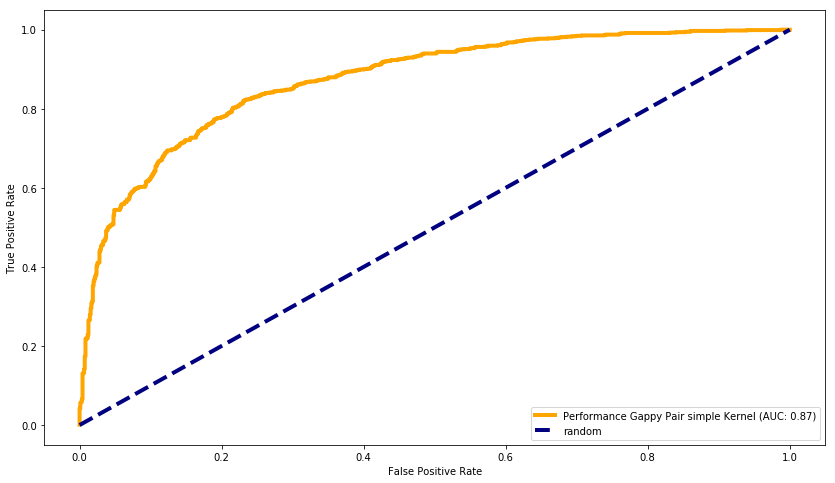

In [25]:
y_score = clf.predict_proba(X_test)
roc_auc = roc_auc_score(y_score=y_score[:,1], y_true=y_test)
tpr, fpr, _ = roc_curve(y_score=y_score[:,1], y_true=y_test)
y_score3 = clf3.predict_proba(X_test3)
roc_auc3 = roc_auc_score(y_score=y_score3[:,1], y_true=y_test3)
tpr, fpr, _ = roc_curve(y_score=y_score3[:,1], y_true=y_test3)
fig = plt.figure(figsize=(14, 8))
plt.plot(tpr, fpr, label='Performance Gappy Pair simple Kernel (AUC: {:0.2f})'.format(roc_auc), lw=4, color='orange')
plt.plot(tpr3, fpr3, label='Performance Gappy Pair simple Kernel gapDifferent false (AUC: {:0.2f})'.format(roc_auc),lw=4, color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', lw=4, linestyle='--', label='random')
plt.legend(loc='lower right')

In [127]:
# Necessary, because the gappy pair trie kernel at the moment can't handle N nucleotides
def remove_n(seqs):
    data=[]
    for x in seqs:
        if Seq('N') in x:
            pass
        else:
            data.append(x)
    return data

neg_without_n=remove_n(neg)

start = time.time()
spectrum_pos2 = gt.gappypair_kernel(pos, k, 0, g=g,  include_flanking=False, gapDifferent = False)
print ("Calculated {}-gappypair trie in {} seconds".format(k, time.time() - start))
start = time.time()
spectrum_neg2 = gt.gappypair_kernel(neg_without_n, k, 0, g=g,  include_flanking=False,gapDifferent = False)
print ("Calculated {}-gappypair trie in {} seconds".format(k, time.time() - start))

In [129]:
X2 =  vstack([spectrum_pos2,spectrum_neg2]).toarray()
y2 =  np.concatenate((np.ones(spectrum_pos2.shape[0]), -np.ones(spectrum_neg2.shape[0])))

In [133]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2,test_size=0.1,random_state=42,stratify=y2)

In [134]:
start = time.time()
clf2 = SVC(C=0.1, kernel='linear', probability=True)
clf2.fit(X_train2, y_train2)
print ("Trained linear SVM on {}-spectrum in {} seconds".format(k, time.time() - start))

Trained linear SVM on 3-spectrum in 226.10187911987305 seconds


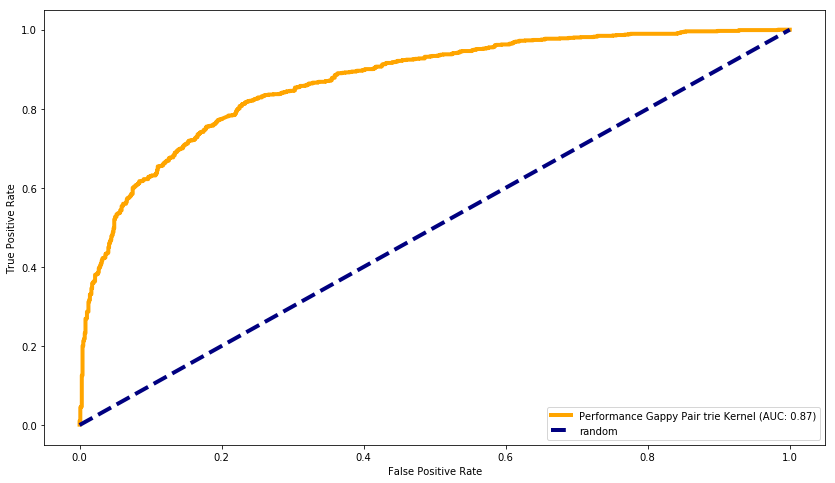

In [137]:
y_score2 = clf2.predict_proba(X_test2)
roc_auc2 = roc_auc_score(y_score=y_score2[:,1], y_true=y_test2)
tpr, fpr, _ = roc_curve(y_score=y_score2[:,1], y_true=y_test2)
fig = plt.figure(figsize=(14, 8))
plt.plot(tpr, fpr, label='Performance Gappy Pair trie Kernel (AUC: {:0.2f})'.format(roc_auc2),         lw=4, color='orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', lw=4, linestyle='--', label='random')
plt.legend(loc='lower right')

(12288,)
(12288,)


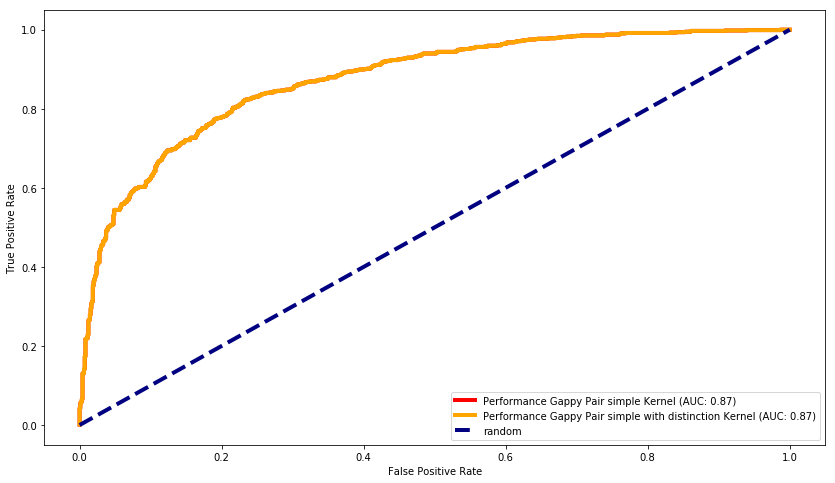

In [4]:
k=3
g=2
start = time.time()
gk.gappypair_kernel(pos, k=k, g=g,  include_flanking=False, reverse=True, gapDifferent = True)
print ("Calculated {}-gappypair in {} seconds".format(k, time.time() - start))
start = time.time()
gk.gappypair_kernel(pos,k=k, g=g,  include_flanking=True, gapDifferent = True)
print ("Calculated {}-gappypair in {} seconds".format(k, time.time() - start))
start = time.time()
gk.gappypair_kernel(pos, k=k, g=g,  include_flanking=False, reverse =True, gapDifferent = False)
print ("Calculated {}-gappypair in {} seconds".format(k, time.time() - start))
start = time.time()
gk.gappypair_kernel(pos, k=k, g=g,  include_flanking=True, gapDifferent = False)
print ("Calculated {}-gappypair in {} seconds".format(k, time.time() - start))
start = time.time()
gk.gappypair_kernel(pos, k=3, g=4,  include_flanking=True, gapDifferent = True)
print ("Calculated {}-gappypair in {} seconds".format(k, time.time() - start))
start = time.time()
gk.gappypair_kernel(pos, k=3, g=4,  include_flanking=True, gapDifferent = False)
print ("Calculated {}-gappypair in {} seconds".format(k, time.time() - start))

Calculated 3-gappypair in 25.034932374954224 seconds
Calculated 3-gappypair in 297.871458530426 seconds
Calculated 3-gappypair in 27.79260778427124 seconds
Calculated 3-gappypair in 310.59016513824463 seconds
Calculated 3-gappypair in 542.6815180778503 seconds
Calculated 3-gappypair in 511.9201674461365 seconds
